# Lending Club Loan pre-issue credit risk model

## Update log

* __20170328__: Initial script
* __20170608__: Updated the code under pandas 0.20.2 version
* __20170611__: Rebuilt core model for pre-issue variables

## Scope of modeling

This script is used to build the pre-issue credit risk model.

1. We focus on __closed deals__ only and try to classify between __default__ loans and __non-default__ loans. Current ongoing loans and fresh issued loan is not included in the scope of modeling.
2. Since this is a __pre-issue credit risk model__ instead of a model for __real-time default detection__, only __variables collected prior to the issue day of the loan__ will be included as predictor variables (like loan information, current credit history). We do not include variables that are collected real-time throughout the loan period (like last payment day).

In [283]:
import random
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, make_scorer, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

## Load Data from csv

In [2]:
# read csv (441.8 MB)
loan = pd.read_csv("../data/loan.csv", low_memory=False)
loan_copy = loan.copy()
# check dimension
print loan.shape

(887379, 74)


In [67]:
# reset loan variable
loan = loan_copy.copy()

## Set up response variable

In [68]:
# all categories of loan_status
loan['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Loans with status "Current" represent loans that haven't been closed till Jan-2016 (the latest payment month in our data). For this analysis, we focus on closed deals only and try to classify between default and non-default.

The loan_status of closed deals are:

* __Fully Paid__ (non-default)
* __Charged Off__ (default)
* __Default__ (defualt)

In [69]:
# filter response categories
loan = loan[loan['loan_status'].isin(['Fully Paid','Charged Off','Default'])]
# set up binary response variable
default = loan['loan_status'].map({"Fully Paid": 0.0,"Charged Off": 1.0,"Default": 1.0})
loan['default'] = default
# delete loan_status from data frame
# loan.drop('loan_status', axis=1, inplace=True)

In [70]:
# check dimension
print loan.shape
print default.shape

(254190, 75)
(254190,)


## Set up predictor variables

In [71]:
# check column names
loan.columns.sort_values()

Index([u'acc_now_delinq', u'addr_state', u'all_util', u'annual_inc',
       u'annual_inc_joint', u'application_type', u'collection_recovery_fee',
       u'collections_12_mths_ex_med', u'default', u'delinq_2yrs', u'desc',
       u'dti', u'dti_joint', u'earliest_cr_line', u'emp_length', u'emp_title',
       u'funded_amnt', u'funded_amnt_inv', u'grade', u'home_ownership', u'id',
       u'il_util', u'initial_list_status', u'inq_fi', u'inq_last_12m',
       u'inq_last_6mths', u'installment', u'int_rate', u'issue_d',
       u'last_credit_pull_d', u'last_pymnt_amnt', u'last_pymnt_d',
       u'loan_amnt', u'loan_status', u'max_bal_bc', u'member_id',
       u'mths_since_last_delinq', u'mths_since_last_major_derog',
       u'mths_since_last_record', u'mths_since_rcnt_il', u'next_pymnt_d',
       u'open_acc', u'open_acc_6m', u'open_il_12m', u'open_il_24m',
       u'open_il_6m', u'open_rv_12m', u'open_rv_24m', u'out_prncp',
       u'out_prncp_inv', u'policy_code', u'pub_rec', u'purpose', u'pymnt_p

### 1. Keep pre-issue variables only

Pre-issue variables are variables representing basic loan information, borrower's demographic, income, credit history and other information collected when applying for loan. They are:

* addr_state
* annual_inc
* annual_inc_joint
* application_type
* desc
* earliest_cr_line
* emp_length
* emp_title
* grade
* home_ownership
* id
* initialListStatus
* installment
* int_rate
* issue_d
* loan_amnt
* member_id
* policy_code
* purpose
* pymnt_plan
* sub_grade
* term
* title
* url
* verified_status_joint
* zip_code

In [72]:
# keep pre-issue variables
loan = loan[['addr_state','annual_inc','annual_inc_joint','application_type','desc','earliest_cr_line',
             'emp_length','emp_title','grade','home_ownership','id','initial_list_status','installment',
             'int_rate','issue_d','loan_amnt','member_id','policy_code','purpose','pymnt_plan',
             'sub_grade','term','title','url','verification_status','zip_code','default']]
loan.shape

(254190, 27)

### 2. Drop irrelevant variables.

In [73]:
# drop irrelavent variables
loan.drop(['id','member_id', 'desc', 'title', 'url', 'zip_code'], axis=1, inplace=True)
# check dimension
loan.shape

(254190, 21)

### 3. Check missing values

In [74]:
# NA count table
NAs = pd.concat([loan.isnull().sum(), np.round(loan.isnull().sum()/len(loan), 3)], axis=1, keys=['missing counts','missing percentage'])

In [75]:
# print all variables that have NAs
NAs[NAs['missing percentage'] > 0.].sort_values('missing percentage')

,missing counts,missing percentage
emp_title,14007,0.055
annual_inc_joint,254189,1.000


In [76]:
# drop annual_inc_joint
loan.drop('annual_inc_joint', axis=1, inplace=True)

### 4. Exploration and Feature engineering

1. generate new variable using existing variables
2. drop redundant variables
3. change variable to proper data type

In [77]:
loan.columns

Index([u'addr_state', u'annual_inc', u'application_type', u'earliest_cr_line',
       u'emp_length', u'emp_title', u'grade', u'home_ownership',
       u'initial_list_status', u'installment', u'int_rate', u'issue_d',
       u'loan_amnt', u'policy_code', u'purpose', u'pymnt_plan', u'sub_grade',
       u'term', u'verification_status', u'default'],
      dtype='object')

top 5 highest default rate by __addr_state__ (address state)

In [79]:
loan.groupby('addr_state')['default'].agg(['mean','count']).sort_values('mean',ascending=False).iloc[0:5,].rename(columns={'mean':'default rate'})

,default rate,count
addr_state,,
TN,0.238971,2448
IN,0.228805,2819
NV,0.216371,3836
AL,0.212611,3156
MS,0.211765,425


top 5 lowest default rate by __addr_state__

In [80]:
loan.groupby('addr_state')['default'].agg(['mean','count']).sort_values('mean',ascending=True).iloc[0:5,].rename(columns={'mean':'default rate'})

,default rate,count
addr_state,,
ND,0.000000,8
ME,0.000000,13
NE,0.105263,38
DC,0.106079,839
MT,0.136119,742


__annual_inc__ (annual income) by default outcome

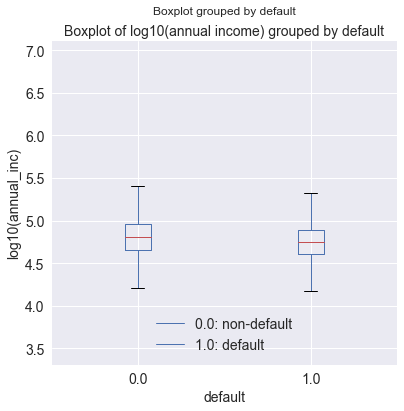

In [81]:
pd.DataFrame({'annual_inc':np.log10(loan['annual_inc']), 'default':loan['default']}).boxplot(column='annual_inc',by='default',figsize=(6,6),fontsize=14)
plt.title('Boxplot of log10(annual income) grouped by default',fontsize=14)
plt.legend(['0.0: non-default','1.0: default'],fontsize=14)
plt.xlabel('default',fontsize=14)
plt.ylabel('log10(annual_inc)',fontsize=14)

In [82]:
# grouped bar plot
# groupby = loan.groupby('default')['annual_inc'].agg(['mean','std','count',lambda x: x.std()/np.sqrt(len(x))]).rename(columns={'<lambda>':'std_err'})
# groupby['mean'].plot.bar(yerr=groupby['std_err'],figsize=(6,4))

__emp_title__: Top 10 employment titles with highest and lowest default rate (group size > 100)

In [83]:
sum(loan['emp_title'].value_counts().nlargest(50))

21407

In [85]:
summary = loan.groupby('emp_title')['default'].agg(['count','mean'])
summary[summary['count'] > 100].sort_values('mean',ascending=False).iloc[:10].rename(columns={'mean':'default rate'})

,count,default rate
emp_title,,
owner,246,0.357724
Server,137,0.343066
nurse,104,0.307692
Operator,123,0.300813
Machinist,102,0.294118
manager,590,0.291525
US Postal Service,127,0.283465
truck driver,270,0.281481
driver,384,0.281250


In [86]:
summary[summary['count'] > 100].sort_values('mean',ascending=True).iloc[:10].rename(columns={'mean':'default rate'})

,count,default rate
emp_title,,
Software Engineer,235,0.063830
Lockheed Martin,126,0.071429
Branch Manager,236,0.072034
Regional Manager,107,0.074766
Physician,102,0.088235
Vice President,380,0.089474
Financial Advisor,120,0.091667
Accounting Manager,104,0.096154
Program Manager,176,0.096591


__issue_d, earliest_cr_line__: take the difference to get the number of days since earliest credit line.

In [87]:
# convert to date
loan['issue_d'] = pd.to_datetime(loan['issue_d'])
loan['earliest_cr_line'] = pd.to_datetime(loan['earliest_cr_line'])

# take the difference
loan['days_since_earliest_cr_line'] = (loan['issue_d'] - loan['earliest_cr_line']).dt.days

# drop issue_d and earliest_cr_line
loan.drop(['issue_d', 'earliest_cr_line'], axis=1, inplace=True)

__grade, sub_grade__: transform to ordinal scale (1 to 35). Lower value represents better grade.

In [89]:
print loan['grade'].unique()
print loan['sub_grade'].unique()
print len(loan['sub_grade'].unique())

# map the grades to a continuous variable
loan['grade_level'] = loan['sub_grade'].map({'A1':1,'A2':2,'A3':3,'A4':4,'A5':5,
                      'B1':6,'B2':7,'B3':8,'B4':9,'B5':10,
                      'C1':11,'C2':12,'C3':13,'C4':14,'C5':15,
                      'D1':16,'D2':17,'D3':18,'D4':19,'D5':20,
                      'E1':21,'E2':22,'E3':23,'E4':24,'E5':25,
                      'F1':26,'F2':27,'F3':28,'F4':29,'F5':30,
                      'G1':31,'G2':32,'G3':33,'G4':34,'G5':35,})

# delete grade, sub_grade
loan.drop(['grade', 'sub_grade'], axis=1, inplace=True)

['B' 'C' 'A' 'E' 'F' 'D' 'G']
['B2' 'C4' 'C5' 'C1' 'A4' 'E1' 'F2' 'B5' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4' 'C2'
 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F1' 'E5' 'G4' 'E2' 'G2'
 'G1' 'F5' 'F4' 'G5' 'G3']
35


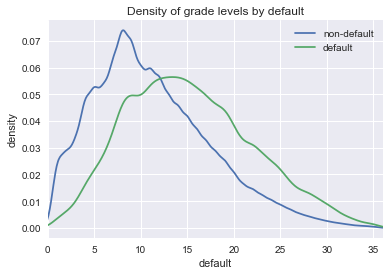

In [90]:
loan.groupby('default')['grade_level'].plot(kind='kde',figsize=(6,4))
plt.xlabel('default')
plt.ylabel('density')
plt.legend(['non-default','default'])
plt.xlim([0,36])
plt.title('Density of grade levels by default')

__emp_length__: Variable emp_length has 11 categories, we cut the them into 4 different ranges.

In [91]:
# before cut
print loan['emp_length'].value_counts()

# cut
loan['emp_length'] = loan['emp_length'].map({'10+ years': '10+ years',
                       '9 years': '6-9 years',
                       '8 years': '6-9 years',
                       '7 years': '6-9 years',
                       '6 years': '6-9 years',
                       '5 years': '3-5 years',
                       '4 years': '3-5 years',
                       '3 years': '3-5 years',
                       '2 years': '0-2 years',
                       '1 year': '0-2 years',
                       '< 1 year': '0-2 years',
                       'n/a': '0-2 years' # no employment information
                      })

# after cut
print loan['emp_length'].value_counts()

10+ years    77256
2 years      23647
< 1 year     20975
3 years      20484
5 years      18136
1 year       16951
4 years      16263
6 years      14816
7 years      14156
8 years      11922
n/a           9968
9 years       9616
Name: emp_length, dtype: int64
10+ years    77256
0-2 years    71541
3-5 years    54883
6-9 years    50510
Name: emp_length, dtype: int64


__pymnt_plan, policy_code, application_type__: Alomost constant. Drop them.

In [92]:
# drop almost-constant variables
print loan['pymnt_plan'].value_counts()
print loan['policy_code'].value_counts()
print loan['application_type'].value_counts()

# delete them
loan.drop(['pymnt_plan', 'policy_code', 'application_type'], axis=1, inplace=True)

n    254188
y         2
Name: pymnt_plan, dtype: int64
1.0    254190
Name: policy_code, dtype: int64
INDIVIDUAL    254189
JOINT              1
Name: application_type, dtype: int64


__home_ownership__: Keep as it is.

In [93]:
loan['home_ownership'].value_counts()

MORTGAGE    125342
RENT        106568
OWN          22095
OTHER          141
NONE            43
ANY              1
Name: home_ownership, dtype: int64

__initial_list_status__: Keep as it is.

In [94]:
loan.groupby('default')['initial_list_status'].value_counts()

default  initial_list_status
0.0      f                      149146
         w                       58577
1.0      f                       33601
         w                       12866
Name: initial_list_status, dtype: int64

__installment__

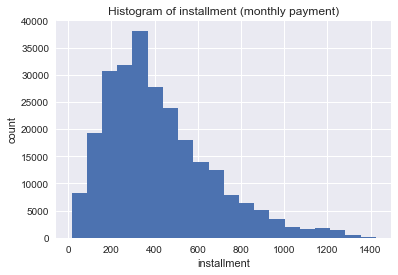

In [95]:
loan['installment'].hist(bins=20, figsize=(6,4))
plt.title('Histogram of installment (monthly payment)')
plt.xlabel('installment')
plt.ylabel('count')

__int_rate__: APR of loan

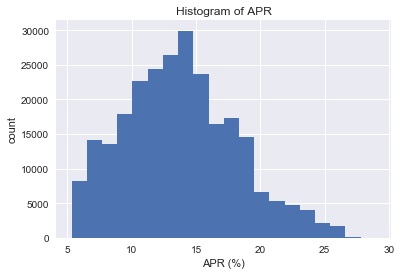

In [96]:
loan['int_rate'].hist(bins=20, figsize=(6,4))
plt.title('Histogram of APR')
plt.xlabel('APR (%)')
plt.ylabel('count')

__loan_amnt__: The listed amount of the loan applied for by the borrower.

In [97]:
loan['loan_amnt'].describe()

count    254190.000000
mean      13570.590897
std        8133.386869
min         500.000000
25%        7250.000000
50%       12000.000000
75%       18250.000000
max       35000.000000
Name: loan_amnt, dtype: float64

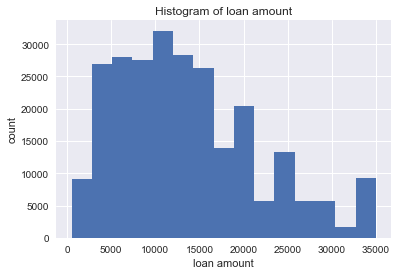

In [98]:
loan['loan_amnt'].hist(bins=15, figsize=(6,4))
plt.title('Histogram of loan amount')
plt.xlabel('loan amount')
plt.ylabel('count')

__purpose__

In [99]:
loan['purpose'].value_counts()

debt_consolidation    149153
credit_card            50309
home_improvement       14976
other                  14342
major_purchase          6279
small_business          4765
car                     3656
medical                 2869
moving                  2039
wedding                 1955
house                   1659
vacation                1596
educational              325
renewable_energy         267
Name: purpose, dtype: int64

__verification_status__

In [100]:
loan.groupby('verification_status')['default'].agg(['mean','count']).rename(columns={'mean':'default rate'})

,default rate,count
verification_status,,
Not Verified,0.144611,86342
Source Verified,0.190700,74473
Verified,0.211823,93375


In [101]:
loan.columns

Index([u'addr_state', u'annual_inc', u'emp_length', u'emp_title',
       u'home_ownership', u'initial_list_status', u'installment', u'int_rate',
       u'loan_amnt', u'purpose', u'term', u'verification_status', u'default',
       u'days_since_earliest_cr_line', u'grade_level'],
      dtype='object')

Now check NAs again.

In [102]:
# NA count table
print loan.shape
NAs = pd.concat([loan.dtypes, loan.isnull().sum(), np.round(loan.isnull().sum()/len(loan), 2)], axis=1, keys=['Type', 'missing counts','missing percentage'])
NAs[NAs['missing counts'] > 0]

(254190, 15)


,Type,missing counts,missing percentage
emp_title,object,14007,0.06


## Modeling

### 1. Performance Metric

We use AUC (Area-under-the-curve) as an optimization metric. This is a popular metric within credit modeling.

In [127]:
def get_auc(y_true, y_pred):
    # y: an array of labels marking the actualy result as default (1) or non-default (0) 
    # y_pred: a probability that a row has defaulted
    # fpr: false-positive rate
    # tpr: true-positive rate
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    return auc_score

### 2. Split training and test data

In [296]:
# setup X and y
X = pd.get_dummies(loan[[u'addr_state', u'annual_inc', u'emp_length', u'home_ownership', u'initial_list_status',
                         u'installment', u'int_rate', u'loan_amnt', u'purpose', u'term', u'verification_status',
                         u'days_since_earliest_cr_line', u'grade_level']])
y = default

In [297]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=5)

In [187]:
print 'Traning sample size: ', len(X_train)
print 'Test sample size', len(X_test)
print 'Columns: ', X_train.columns
print 'Datatypes: ', X_train.dtypes

Traning sample size:  76257
Test sample size 177933
Columns:  Index([u'annual_inc', u'installment', u'int_rate', u'loan_amnt',
       u'days_since_earliest_cr_line', u'grade_level', u'addr_state_AK',
       u'addr_state_AL', u'addr_state_AR', u'addr_state_AZ', u'addr_state_CA',
       u'addr_state_CO', u'addr_state_CT', u'addr_state_DC', u'addr_state_DE',
       u'addr_state_FL', u'addr_state_GA', u'addr_state_HI', u'addr_state_IA',
       u'addr_state_ID', u'addr_state_IL', u'addr_state_IN', u'addr_state_KS',
       u'addr_state_KY', u'addr_state_LA', u'addr_state_MA', u'addr_state_MD',
       u'addr_state_ME', u'addr_state_MI', u'addr_state_MN', u'addr_state_MO',
       u'addr_state_MS', u'addr_state_MT', u'addr_state_NC', u'addr_state_ND',
       u'addr_state_NE', u'addr_state_NH', u'addr_state_NJ', u'addr_state_NM',
       u'addr_state_NV', u'addr_state_NY', u'addr_state_OH', u'addr_state_OK',
       u'addr_state_OR', u'addr_state_PA', u'addr_state_RI', u'addr_state_SC',
       u'a

### 3. Logistic regression

In [293]:
# X_train_scaled = scale(X_train)
# pca = PCA(n_components=40).fit(X_train_scaled)

In [295]:
# pca.explained_variance_ratio_

array([ 0.04508112,  0.0292117 ,  0.02356523,  0.02011151,  0.01913441,
        0.01653975,  0.01594282,  0.01548969,  0.01430727,  0.01394359,
        0.01358448,  0.01303347,  0.01298447,  0.01261094,  0.01244868,
        0.01217605,  0.01209569,  0.01207203,  0.01201433,  0.01199599,
        0.01198023,  0.0119323 ,  0.01192172,  0.01189949,  0.01186086,
        0.01184761,  0.01182987,  0.01181883,  0.01179602,  0.01177757,
        0.01175798,  0.01174738,  0.01173128,  0.01172209,  0.01171345,
        0.01169297,  0.01168034,  0.01165929,  0.01164926,  0.01163065])

In [267]:
# logit = sm.Logit(y_train, X_train)
# result = logit.fit_regularized(method='l1',maxiter=1000)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.440488793658
            Iterations: 626
            Function evaluations: 654
            Gradient evaluations: 626


LinAlgError: Singular matrix

In [264]:
# print result.summary()

                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               203352
Model:                          Logit   Df Residuals:                   203320
Method:                           MLE   Df Model:                           31
Date:                Sun, 11 Jun 2017   Pseudo R-squ.:                 0.07445
Time:                        14:20:56   Log-Likelihood:                -89434.
converged:                      False   LL-Null:                       -96629.
                                        LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
annual_inc                          -7.116e-06   2.08e-07    -34.199      0.000   -7.52e-06   -6.71e-06
installment                             0.0003      0.00

### 4. Random Forest

In [298]:
# Random Forest classifier
rf = RandomForestClassifier(bootstrap=True, class_weight='balanced', n_estimators=50)

# tune n_estimators, use AUC score for cross validation instead of accuracy
# rf = GridSearchCV(estimator=rf, scoring=make_scorer(get_auc), param_grid=dict(n_estimators=np.arange(10,100,10)), cv=5, n_jobs=-1)
rf.fit(X_train, y_train)
print "Best number of trees: ", rf.n_estimators

# probability prediction
rf_pred = rf.predict_proba(X_test)[:,1]

# AUC score
rf_auc_score = get_auc(y_true=y_test, y_pred=rf_pred)
print "Random Forest - model AUC: %s" % auc_score

Best number of trees:  50
Random Forest - model AUC: 0.664397355351


Now we look at the variable importances.

In [299]:
rf.feature_importances_.sum()

1.0

The sum of variable importances is 1. It is reasonable to sum up importances of all categories within a categorical variable to get its importance.

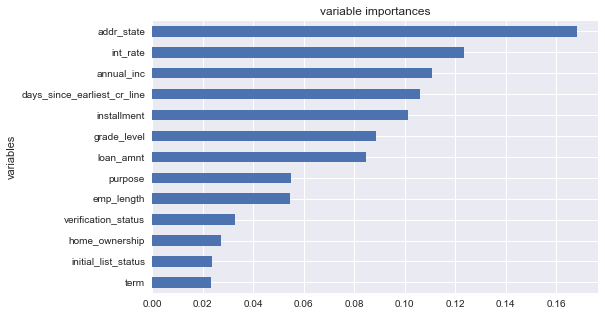

In [300]:
# calculate variable importances
importances = pd.Series(rf.feature_importances_, index=list(X_train.columns))
importances_original_var = pd.Series(rf.feature_importances_, index=list(X_train.columns))

# group categories into their original variables
for var in list(loan.columns):
    importances_original_var[importances.index.str.contains(var)] = var
importances = pd.DataFrame({'importance':importances, 'var':importances_original_var}).groupby('var')['importance'].sum()

# plot
importances.sort_values(ascending=True).plot(kind='barh',figsize=(8,5))
plt.title('variable importances')
plt.ylabel('variables')

### 5. GBM

In [301]:
# fit untuned Random Forest model
gbm = GradientBoostingClassifier(subsample=0.7, n_estimators=50)

# tune n_estimators, use AUC score for cross validation instead of accuracy
# gbm = GridSearchCV(estimator=gbm,
#                     scoring=make_scorer(get_auc),
#                     param_grid=dict(n_estimators=np.arange(50,150,10)),
#                     cv=5,
#                     n_jobs=-1)
gbm.fit(X_train, y_train)
print "Best number of boosting stages: ", gbm.n_estimators

# probability prediction
gbm_pred = gbm.predict_proba(X_test)[:,1]

# AUC score
gbm_auc_score = get_auc(y_test, gbm_pred)
print "Random Forest - model AUC: %s" % gbm_auc_score

Best number of boosting stages:  50
Random Forest - model AUC: 0.698652621892


### 6. Performance evaluation

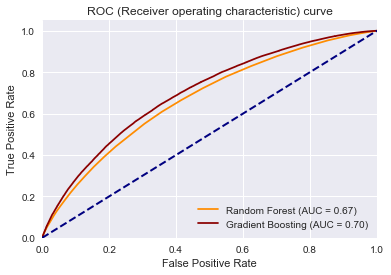

In [304]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, rf_pred)
fpr2, tpr2, thresholds2 = roc_curve(y_test, gbm_pred)
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', label='Random Forest (AUC = {0:0.2f})'.format(rf_auc_score))
plt.plot(fpr2, tpr2, color='darkred', label='Gradient Boosting (AUC = {0:0.2f})'.format(gbm_auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver operating characteristic) curve')
plt.legend(loc="lower right")
plt.show()